# Quick Look Validation Plots

In this notebook I'm developing a class to evaluate the source finding algorithms. The main metrics use here are completeness and contamination.


In [1]:
import numpy as np

import glob

from astropy.table import Table, join, vstack
from astropy.io import fits

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline


# Load Files

In [3]:
fnames = glob.glob('data/gaia_matched_*')
fnames[:5]

['data/gaia_matched_2021070700199.fits',
 'data/gaia_matched_2021070700177.fits',
 'data/gaia_matched_2021110400613.fits',
 'data/gaia_matched_2022031600689.fits',
 'data/gaia_matched_2020031400335.fits']

In [4]:
def get_expid(fname):
    return int(fname.split('.fits')[0][-13:])


In [5]:
table = Table(fits.getdata('gaia_matched_feb2020-nov2021_feb-march2022.fits'))

In [6]:
# tables = []
new_expIds = []
for i,fname in enumerate(fnames):
    # print(f'{i}: {fname}')
    # tables.append(Table(fits.getdata(fname)))
    new_expIds.append(get_expid(fname))
    
# table = vstack(tables)
# table.write('gaia_matched_feb2020-nov2021_feb-march2022.fits',format='fits',overwrite=True)

In [7]:
## Define all masks

gaia = np.isfinite(table['ref_ra'])
auxtel = np.isfinite(table['base_SdssCentroid_x'])
only_gaia = np.isnan(table['base_CircularApertureFlux_3_0_instFlux'])
only_auxtel = (np.isnan(table['ref_ra']))
matched = table['id_match']>0.
good = (table['base_CircularApertureFlux_3_0_instFlux']/table['base_CircularApertureFlux_3_0_instFluxErr'] > 5.) | only_gaia


In [8]:
table[matched][:10]

base_SdssCentroid_x,base_SdssCentroid_y,base_CircularApertureFlux_3_0_instFlux,base_CircularApertureFlux_3_0_instFluxErr,ra,dec,gaia,id_match,source_id,ref_ra,ref_dec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,radius_val,ref_base_SdssCentroid_x,ref_base_SdssCentroid_y,dist,auxtel,EXPID,DATE,FILTER,EXPTIME,X0,Y0
float64,float64,float64,float64,float64,float64,bool,int64,int64,float64,float64,float32,float32,float32,float32,float64,float64,float64,bool,int64,str23,str8,float64,float64,float64
610.5715714688707,233.4798854220711,86508.15625,280.5949401855469,232.01969234374317,-6.396020652043244,True,14,6321899703153257216,232.01976622279173,-6.396012553605228,13.985704,14.44106,13.382994,0.7861012,609.9353221865438,236.18494956490463,0.26673365301630103,True,2021070700199,2021-07-08T01:45:54.640,RG610,5.0,2088.0000000000005,2005.9999999999998
1631.5631407656979,746.1880553955045,3019.46923828125,72.51581573486328,232.03000174190188,-6.424606960313018,True,56,6321899389619482496,232.03000675904605,-6.424604702393239,17.700457,18.233562,16.98371,nan,1631.4561535522162,746.3639748958942,0.019754738071390127,True,2021070700199,2021-07-08T01:45:54.640,RG610,5.0,2088.0000000000005,2005.9999999999998
1466.9741697066047,823.2433448385359,3323.143798828125,74.71795654296875,232.03258020425613,-6.420511647945476,True,60,6321899393915611520,232.03259871346353,-6.420491991784264,17.350958,17.656977,16.860073,nan,1466.156491258082,823.8408127763962,0.09705366976955994,True,2021070700199,2021-07-08T01:45:54.640,RG610,5.0,2088.0000000000005,2005.9999999999998
2873.79018609755,995.7746714713664,3423.336669921875,78.41597747802734,232.0326097270531,-6.458185535419985,True,71,6321894858430145792,232.03264186700662,-6.458168745460731,17.32259,17.727766,16.736948,nan,2873.0179851314238,996.8909578162688,0.13021475800027152,True,2021070700199,2021-07-08T01:45:54.640,RG610,5.0,2088.0000000000005,2005.9999999999998
1185.3390815258701,1475.112458803499,991854.4375,946.1824951171875,232.05079940317432,-6.415173742508034,True,96,6321896473337849984,232.05073903821224,-6.4151043711573585,11.227886,11.615685,10.699302,0.85940087,1183.0209672317706,1472.5565781227801,0.33060265329890276,True,2021070700199,2021-07-08T01:45:54.640,RG610,5.0,2088.0000000000005,2005.9999999999998
948.7547526672479,1664.6206630952677,70569.40625,255.1947784423828,232.05659625803813,-6.40953969499632,True,101,6321896576417065216,232.0566000645181,-6.409542612391478,14.276947,14.80846,13.605979,4.873766,948.8465164813481,1664.7752035364897,0.017231149725957007,True,2021070700199,2021-07-08T01:45:54.640,RG610,5.0,2088.0000000000005,2005.9999999999998
3746.0531057542407,1658.5548175594022,2481.5478515625,65.98963165283203,232.04738744515456,-6.483329154220139,True,102,6321894476176854656,232.04740193457008,-6.483319097770775,17.435577,17.816944,16.899017,nan,3745.612113392678,1659.0467327440851,0.06335720803148452,True,2021070700199,2021-07-08T01:45:54.640,RG610,5.0,2088.0000000000005,2005.9999999999998
2800.6495190180412,2162.3999174509786,4089.333984375,75.20264434814453,232.0638246421957,-6.460001469653973,True,134,6321894613615825024,232.06382327083548,-6.460004063978787,17.39209,18.099113,16.541838,nan,2800.7525971454984,2162.360826726775,0.010556787024252987,True,2021070700199,2021-07-08T01:45:54.640,RG610,5.0,2088.0000000000005,2005.9999999999998
2597.7953893270364,2300.696507927152,3595.61083984375,72.30077362060547,232.06815293581104,-6.455092900551542,True,138,6321896091084578176,232.0681466587324,-6.455094699903944,17.641054,18.511631,16.71771,nan,2597.890924210971,2300.4717502639496,0.02343862364198961,True,2021070700199,2021-07-08T01:45:54.640,RG610,5.0,2088.0000000000005,2005.9999999999998


## Plot Distributions

In [9]:
mag = np.array(table['phot_g_mean_mag'])
flux = np.array(table['base_CircularApertureFlux_3_0_instFlux'])
log_flux = np.log10(flux)

flux[np.isnan(flux)] = -1.
log_flux[np.isnan(log_flux)] = -1.

flux_gt0 = log_flux>0.

snr = table['base_CircularApertureFlux_3_0_instFlux']/table['base_CircularApertureFlux_3_0_instFluxErr']

/tmp/ipykernel_27488/3874702086.py:3: RuntimeWarning: invalid value encountered in log10
  log_flux = np.log10(flux)


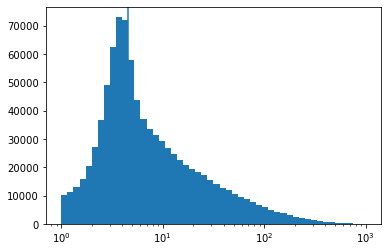

In [10]:
plt.hist(snr,bins=np.logspace(0.,3,51))
plt.axvline(4.5)
plt.xscale('log')

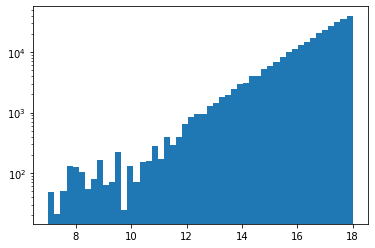

In [11]:
plt.hist(mag[gaia],bins=np.linspace(7,18,51))
plt.yscale('log')

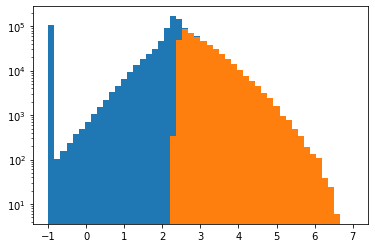

In [12]:
plt.hist(log_flux[auxtel],bins=np.linspace(-1,7.,51))
plt.hist(log_flux[auxtel&good],bins=np.linspace(-1.,7.,51))
plt.yscale('log')

## Compute Detection Rate

In [13]:
from utils import compute_fraction_err, plot_curve

In [14]:
mag_0 = 11.
mvec = np.arange(mag_0,18.+0.05,0.05)
m_frac = compute_fraction_err(mvec, mag[gaia], matched[gaia], bw=0.05, nBootStrap=100, error=True)
m_frac_mask = compute_fraction_err(mvec, mag[gaia&good], (matched)[gaia&good], bw=0.05, nBootStrap=100, error=True)

In [25]:
fvec = np.log10(np.logspace(1.,log_flux.max(),100))
frac_log = compute_fraction_err(fvec, log_flux[auxtel&flux_gt0], matched[auxtel&flux_gt0], bw=0.1, nBootStrap=100, error=True)
frac_log_mask = compute_fraction_err(fvec, log_flux[auxtel&good&flux_gt0], matched[auxtel&good&flux_gt0], bw=0.1, nBootStrap=100, error=True)


NameError: name 'flux_gt0' is not defined

ValueError: x and y must have same first dimension, but have shapes (72,) and (141,)

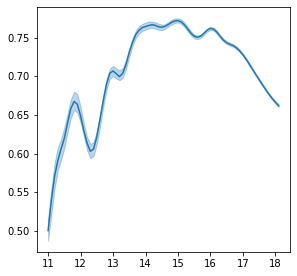

In [26]:
fig = plt.figure(figsize=(10,4.5))

plt.subplot(1, 2, 1)
plot_curve(mvec ,m_frac, label=f'{len(new_expIds)} Fields', ax=plt)
plot_curve(mvec ,m_frac_mask, label='flux/fluxErr>5.',ax=plt)
plt.legend(fontsize=14)
plt.xlabel('gaia: mag_g',fontsize=14)
plt.ylabel('Detection Rate',fontsize=16)
plt.title('Gaia Sources',fontsize=16)
#plt.tight_layout()
# plt.ylim(-0.05,1.1)

plt.subplot(1, 2, 2)
plot_curve(10**fvec,frac_log,ax=plt)
plot_curve(10**fvec,frac_log_mask,ax=plt)
plt.xscale('log')
# plt.axhline(1)
# plt.legend(fontsize=14)
plt.xlabel('base_CircularApertureFlux_3_0_instFlux',fontsize=14)
# plt.ylabel('AuxTel Detection Rate',fontsize=16)
plt.title('AuxTel Sources',fontsize=16)
# plt.ylim(-0.05,1.1)
# plt.tight_layout()

fig.suptitle(f'Observation Runs - Feb 2020 up to Nov 2021 and Feb&Mar 2022',fontsize=16)
fig.tight_layout()
plt.savefig('auxtel_detection_rate_preliminary.png',facecolor='w',transparent=False,dpi=150)

## Cycles and CCD Filter

In [17]:
one = (table['EXPID'] < 2022010700000)
feb = (table['EXPID'] > 2022010700000)&(table['EXPID'] < 2022030100000)
mar = (table['EXPID'] > 2022030100000)

In [18]:
bw=0.2
mvec = np.arange(mag_0,18.+bw/2.,bw/2.)
m_frac = compute_fraction_err(mvec, mag[gaia], matched[gaia], bw=bw, nBootStrap=100, error=True)
m_frac_one = compute_fraction_err(mvec, mag[gaia&one], matched[gaia&one], bw=bw, nBootStrap=100, error=True)
m_frac_feb = compute_fraction_err(mvec, mag[gaia&feb], matched[gaia&feb], bw=bw, nBootStrap=100, error=True)
m_frac_mar = compute_fraction_err(mvec, mag[gaia&mar], matched[gaia&mar], bw=bw, nBootStrap=100, error=True)


In [19]:
mDict = {'2020-2021':m_frac_one,'feb2022':m_frac_feb, 'mar2022':m_frac_mar}

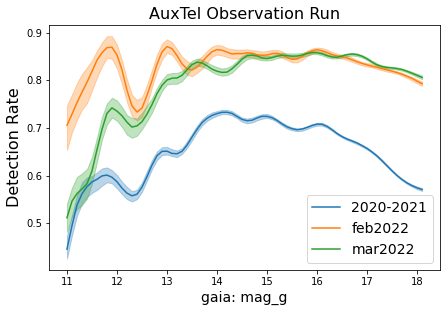

In [20]:
fig = plt.figure(figsize=(7,4.5))

for col in mDict.keys():
    plot_curve(mvec ,mDict[col], label=col, ax=plt)

plt.legend(fontsize=14)
plt.xlabel('gaia: mag_g',fontsize=14)
plt.ylabel('Detection Rate',fontsize=16)
plt.title('AuxTel Observation Run',fontsize=16)
#plt.tight_layout()
# plt.ylim(-0.05,1.1)
plt.savefig('auxtel_detection_rate_cycles.png',facecolor='w',transparent=False,dpi=150)

In [21]:
bw=0.2
mvec = np.arange(mag_0,18.+bw/2.,bw/2.)


In [22]:
RG610 = (table['FILTER']=='RG610')
FELH0600 = (table['FILTER']=='FELH0600')
SDSSg = (table['FILTER']=='SDSSg')
SDSSr = (table['FILTER']=='SDSSr')
SDSSi = (table['FILTER']=='SDSSi')

fDict = dict()
mask_list = {'RG610':RG610,'FELH0600':FELH0600,'SDSSg':SDSSg,'SDSSr':SDSSr,'SDSSi':SDSSi}
for li,mi in mask_list.items():
    print(f'{li}: {np.count_nonzero(mi)}')
    fDict[li] = compute_fraction_err(mvec, mag[gaia&mi], matched[gaia&mi], bw=bw, nBootStrap=100, error=True)

RG610: 408128
FELH0600: 162697
SDSSg: 299022
SDSSr: 131613
SDSSi: 109561


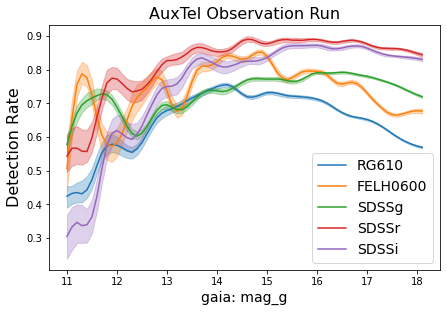

In [23]:
fig = plt.figure(figsize=(7,4.5))

for col in fDict.keys():
    plot_curve(mvec ,fDict[col], label=col, ax=plt)

plt.legend(fontsize=14)
plt.xlabel('gaia: mag_g',fontsize=14)
plt.ylabel('Detection Rate',fontsize=16)
plt.title('AuxTel Observation Run',fontsize=16)
#plt.tight_layout()
# plt.ylim(-0.05,1.1)
plt.savefig('auxtel_detection_rate_filters.png',facecolor='w',transparent=False,dpi=150)

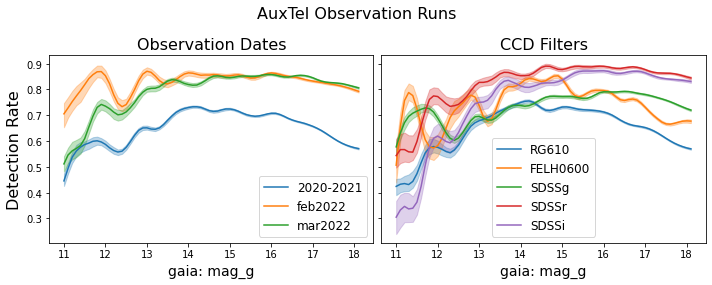

In [24]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4.), sharex=True, sharey=True)

for col in mDict.keys():
    plot_curve(mvec ,mDict[col], label=col, ax=ax1)

ax1.legend(fontsize=12)
ax1.set_xlabel('gaia: mag_g',fontsize=14)
ax1.set_ylabel('Detection Rate',fontsize=16)
ax1.set_title('Observation Dates',fontsize=16)
# plt.ylim(0.3,0.92)

# plt.subplot(1, 2, 2)
for col in fDict.keys():
    plot_curve(mvec ,fDict[col], label=col, ax=ax2)
ax2.set_xlabel('gaia: mag_g',fontsize=14)
ax2.legend(fontsize=12)
ax2.set_title('CCD Filters',fontsize=16)
# plt.ylim(0.3,0.92)
fig.suptitle(f'AuxTel Observation Runs',fontsize=16)

fig.tight_layout()
fig.subplots_adjust(wspace=0.025)
plt.savefig('auxtel_detection_rate_cycle_filters_preliminary.png',facecolor='w',transparent=False,dpi=150)